The overall plan of this code is to create a model that deduces the daily AQI (air quality index) based on the number of cars without measuring the air composition.
For that, a column named AQI will firstly be added to the fulldata_daily dataframe.
Using this dataframe, different algorithms along with crossvalidation will be tried to create a model that classifies the observed data into correct AQI, only based on the number of cars data.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('../processed_data/full_data.csv')
df.head()

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,Hr,RainDur,...,WVs,StrGlo,p,NO2,NO,NOx,O3,CO,PM10,SO2
0,2007,1,1,00:00,2007-01-01T00:00,NaN,NaN,NaN,65.26,0.00,...,3.79,1.48,975.65,19.80,1.70,11.71,45.31,0.30,53.27,7.88
1,2007,1,1,01:00,2007-01-01T01:00,NaN,NaN,NaN,68.60,5.63,...,5.27,1.50,974.98,13.26,2.88,9.24,54.38,0.27,27.84,3.21
2,2007,1,1,02:00,2007-01-01T02:00,NaN,NaN,NaN,73.04,26.47,...,4.40,1.51,974.43,14.07,1.95,8.92,52.51,0.26,13.06,3.01
3,2007,1,1,03:00,2007-01-01T03:00,NaN,NaN,NaN,78.79,57.95,...,4.11,1.49,973.78,12.26,1.69,7.77,53.81,0.24,10.81,2.97
4,2007,1,1,04:00,2007-01-01T04:00,NaN,NaN,NaN,83.82,41.25,...,2.82,1.48,973.30,32.60,4.90,20.98,25.57,0.33,25.29,3.71


EAQI classifies the stations as 'Traffic stations' or 'Industrial and Background stations'. Stampfenbachstrasse is classified as traffic stations and for traffic stations, only NO2, PM10, PM2.5 are considered to calculate EAQI.
Since our dataset doesn't have PM2.5 we only use NO2 and PM10 to calculate the EAQI.

In [9]:
# Leave out only the variables that I need
df = df.iloc[:,[0,1,2,3,4,5,6,7,14,19]]
df.head()

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,NO2,PM10
0,2007,1,1,00:00,2007-01-01T00:00,NaN,NaN,NaN,19.80,53.27
1,2007,1,1,01:00,2007-01-01T01:00,NaN,NaN,NaN,13.26,27.84
2,2007,1,1,02:00,2007-01-01T02:00,NaN,NaN,NaN,14.07,13.06
3,2007,1,1,03:00,2007-01-01T03:00,NaN,NaN,NaN,12.26,10.81
4,2007,1,1,04:00,2007-01-01T04:00,NaN,NaN,NaN,32.60,25.29


In [10]:
df = df.dropna(subset = ['Zweirad', 'Personenwagen', 'Lastwagen'])

In [11]:
# For NO2, O3, SO2, hourly concentrations are fed into the calculation of index
# For PM10, PM2.5, the 24-hour running means for the past 24 hours are used. (minum of 18 hours needed)

df['PM10_calc'] = df['PM10'].rolling(window=24, min_periods=18).mean()
df

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,NO2,PM10,PM10_calc
7944,2007,11,28,00:00,2007-11-28T00:00,11.0,79.0,4.0,55.87,28.73,NaN
7945,2007,11,28,01:00,2007-11-28T01:00,3.0,57.0,0.0,43.34,26.47,NaN
7946,2007,11,28,02:00,2007-11-28T02:00,3.0,46.0,0.0,34.87,26.22,NaN
7947,2007,11,28,03:00,2007-11-28T03:00,0.0,21.0,2.0,37.67,21.58,NaN
7948,2007,11,28,04:00,2007-11-28T04:00,1.0,30.0,3.0,39.56,33.95,NaN
...,...,...,...,...,...,...,...,...,...,...,...
131422,2021,12,28,23:00,2021-12-28T23:00,2.0,26.0,0.0,2.65,4.29,6.118333
131423,2021,12,29,00:00,2021-12-29T00:00,1.0,23.0,0.0,2.37,4.02,5.882917
131424,2021,12,29,01:00,2021-12-29T01:00,0.0,7.0,0.0,2.35,6.10,5.714583
131425,2021,12,29,02:00,2021-12-29T02:00,0.0,3.0,0.0,1.22,8.25,5.495833


In [12]:
# integrating concentration and index levels according to the EAQI table

range_PM10 = [0, 20, 40, 50, 100, 150, 1200]
range_NO2 = [0, 40, 90, 120, 230, 340, 1000]

# by setting labels=False, AQI will be expressed as integers.
# 0:Good, 1:Fair, 2:Moderate, 3:Poor, 4:VeryPoor, 5:ExtremlyPoor

NO2_bins = pd.cut(df['NO2'], bins=range_NO2, labels=False, include_lowest=True)
df['NO2_AQI'] = NO2_bins

PM10_bins = pd.cut(df['PM10_calc'], bins=range_PM10, labels=False, include_lowest=True)
df['PM10_AQI'] = PM10_bins

# The AQI corresponds to the poorest of any pollutant considered
df['AQI'] = np.fmax(df['NO2_AQI'], df['PM10_AQI'])
df = df.dropna(subset=['AQI'])

df

,Jahr,Monat,Tag,Zeit,Datum,Zweirad,Personenwagen,Lastwagen,NO2,PM10,PM10_calc,NO2_AQI,PM10_AQI,AQI
7944,2007,11,28,00:00,2007-11-28T00:00,11.0,79.0,4.0,55.87,28.73,NaN,1.0,NaN,1.0
7945,2007,11,28,01:00,2007-11-28T01:00,3.0,57.0,0.0,43.34,26.47,NaN,1.0,NaN,1.0
7946,2007,11,28,02:00,2007-11-28T02:00,3.0,46.0,0.0,34.87,26.22,NaN,0.0,NaN,0.0
7947,2007,11,28,03:00,2007-11-28T03:00,0.0,21.0,2.0,37.67,21.58,NaN,0.0,NaN,0.0
7948,2007,11,28,04:00,2007-11-28T04:00,1.0,30.0,3.0,39.56,33.95,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131422,2021,12,28,23:00,2021-12-28T23:00,2.0,26.0,0.0,2.65,4.29,6.118333,0.0,0.0,0.0
131423,2021,12,29,00:00,2021-12-29T00:00,1.0,23.0,0.0,2.37,4.02,5.882917,0.0,0.0,0.0
131424,2021,12,29,01:00,2021-12-29T01:00,0.0,7.0,0.0,2.35,6.10,5.714583,0.0,0.0,0.0
131425,2021,12,29,02:00,2021-12-29T02:00,0.0,3.0,0.0,1.22,8.25,5.495833,0.0,0.0,0.0


Now with the hourly vehicles and AQI data, we can perform classification algorithms.
Starting with K-nearest neighbor

In [15]:
# K-nearest neighbors

from sklearn.model_selection import train_test_split

tr_data, vali_data, tr_label, vali_label = train_test_split(df[['Personenwagen','Lastwagen']], df['AQI'], random_state=100)

print(len(tr_data))
print(len(vali_data))
print(len(tr_label))
print(len(vali_label))

67869
22623
67869
22623


In [31]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=2000)
classifier.fit(tr_data, tr_label)

KNeighborsClassifier(n_neighbors=2000)

In [17]:
print(classifier.score(vali_data, vali_label))

0.5209300269637095


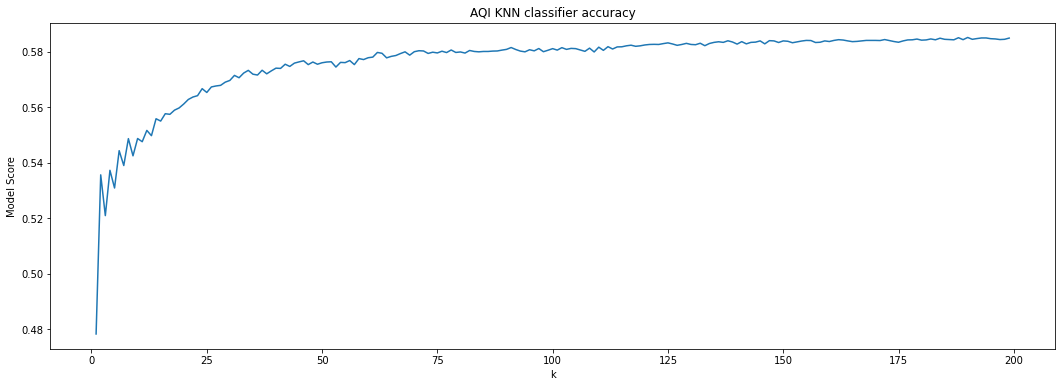

In [22]:
k_list = range(1,200)
accuracies = []

for k in k_list:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(tr_data, tr_label)
    accuracies.append(classifier.score(vali_data, vali_label))

plt.figure(figsize=(18,6))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('AQI KNN classifier accuracy')
plt.show()

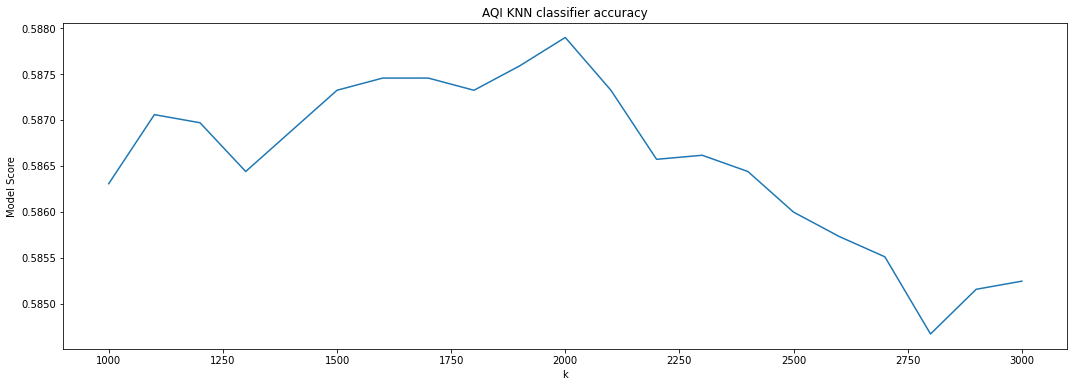

In [26]:
k_ls = list(range(1000, 3001, 100))
score = []

for k in k_ls:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(tr_data, tr_label)
    score.append(classifier.score(vali_data, vali_label))

plt.figure(figsize=(18,6))
plt.plot(k_ls, score)
plt.xlabel('k')
plt.ylabel('Model Score')
plt.title('AQI KNN classifier accuracy')
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score, cross_validate

cv_score = cross_val_score(classifier, df[['Personenwagen', 'Lastwagen']], df['AQI'], scoring='accuracy', cv=3)
print('Cross validation score : {}'.format(np.round(cv_score, 4)))
print('Average score : {}'.format(np.mean(cv_score)))

Cross validation score : [0.5547 0.5865 0.5796]
Average score : 0.573619767493259


In [34]:
print(df['AQI'].value_counts())
# Since we have a very unbalanced dataset where there are a lot of 0 ('Good') AQIs, we perform stratified K-fold cross validation

from sklearn.model_selection import StratifiedKFold

0.0    49703
1.0    35886
2.0     2925
3.0     1978
Name: AQI, dtype: int64